In [70]:
import gym
import math
import time
import numpy as np
import random
from sklearn.preprocessing import KBinsDiscretizer
import seaborn as sns
import matplotlib.pyplot as plt


In [71]:
env = gym.make('FrozenLake-v0')

In [72]:
?env.env

Type:        FrozenLakeEnv
String form: <FrozenLakeEnv<FrozenLake-v0>>
File:        c:\users\taha\anaconda3\lib\site-packages\gym\envs\toy_text\frozen_lake.py
Docstring:  
Winter is here. You and your friends were tossing around a frisbee at the
park when you made a wild throw that left the frisbee out in the middle of
the lake. The water is mostly frozen, but there are a few holes where the
ice has melted. If you step into one of those holes, you'll fall into the
freezing water. At this time, there's an international frisbee shortage, so
it's absolutely imperative that you navigate across the lake and retrieve
the disc. However, the ice is slippery, so you won't always move in the
direction you intend.
The surface is described using a grid like the following

    SFFF
    FHFH
    FFFH
    HFFG

S : starting point, safe
F : frozen surface, safe
H : hole, fall to your doom
G : goal, where the frisbee is located

The episode ends when you reach the goal or fall in a hole.
You receive a 

In [141]:
class QLearningAgent():
    
    def __init__(self, env, state_space, lr, min_epsilon, gamma):
        
        self.env = env
        self.state_space = state_space
        self.Q_table = np.zeros((self.state_space,) + (self.env.action_space.n,))
        self.lr = lr
        self.min_epsilon = min_epsilon
        self.gamma = gamma
    
    def update_epsilon_greedy(self, episode):
        self.epsilon =  max(self.min_epsilon, min(1, 1.0 - math.log10((episode  + 1) / 25)))
    
    def get_action(self, state):
        if np.random.random() < self.epsilon:
            action = self.env.action_space.sample()
        else:
            action = np.argmax(self.Q_table[state])
        return action
    
    def train_Q(self, episodes):
        tic = time.time()
        self.reward_list = []  
        self.plot_rewards = []
        episode_reward = 0
        success = False
        for i in range(1, episodes+1):
            self.update_epsilon_greedy(i)

            current = self.env.reset()
            done = False
            while not done:

                if np.random.random() < self.epsilon:
                    action = env.action_space.sample()
                else:
                    action = np.argmax(self.Q_table[current])

                observation, reward, done, info = self.env.step(action) 
                next_state = observation
                
                self.Q_table[current][action] += self.lr*(reward + (self.gamma*np.max(self.Q_table[next_state])) - self.Q_table[current][action])
                current = next_state

                episode_reward += reward
            
            self.reward_list.append(episode_reward)
            if i >= 500:
                self.plot_rewards.append(np.mean(self.reward_list[-500:]))
            episode_reward = 0
            
        toc = time.time()
        print(f'Finished training state-action function in {toc-tic:.2f} seconds')
        print('===================================================================')
        print(self.Q_table)
        return f'Total rewards over {episodes} episodes: {np.sum(self.reward_list)} and {np.mean(self.reward_list):.2f} average rewards'
    
    def test_Q(self, episodes):
        rewards = []
        episode_reward = 0
        for i in range(1, episodes+1):
            current = env.reset()
            done = False
            while not done:
                action = np.argmax(self.Q_table[current])
                observation, reward, done, info = env.step(action)
                next_state = observation
                episode_reward += reward
                current = next_state
            rewards.append(episode_reward)
            episode_reward = 0
        return f'Total rewards over {episodes} episodes: {np.sum(rewards)} and reached the goal {np.sum(rewards)/episodes}% of the time'
    
    def plot_rewards_per_episode(self):
        sns.set_style('darkgrid')
        f, ax = plt.subplots(figsize=(10,8))
        sns.lineplot(x=range(len(self.plot_rewards)), y=self.plot_rewards, ax=ax)
        ax.set_title('Rolling Average Over Last 100 Episodes', size=17.5)
        ax.set_ylabel('Rewards', size=15)
        ax.set_xlabel('Episodes', size=15)

In [142]:
qlearn = QLearningAgent(env=gym.make('FrozenLake-v0'), state_space=16, lr=0.1, min_epsilon=0.01, gamma=0.99)

In [143]:
qlearn.train_Q(100000)

Finished training state-action function in 110.89 seconds
[[0.58681902 0.48650967 0.46897518 0.4832346 ]
 [0.28480627 0.29490267 0.27283349 0.49812852]
 [0.40991632 0.24401483 0.26999961 0.27385836]
 [0.156653   0.         0.02626276 0.        ]
 [0.60370203 0.41693169 0.22640508 0.37072024]
 [0.         0.         0.         0.        ]
 [0.31425115 0.05540304 0.15148688 0.04914547]
 [0.         0.         0.         0.        ]
 [0.45501254 0.34996228 0.40125668 0.62841467]
 [0.34081905 0.6407088  0.42123014 0.42005163]
 [0.53730068 0.37162555 0.30162442 0.24347195]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.49043014 0.47708598 0.76276865 0.55635252]
 [0.70479915 0.88728516 0.74846926 0.70130716]
 [0.         0.         0.         0.        ]]


'Total rewards over 100000 episodes: 67184.0 and 0.67 average rewards'

In [144]:
qlearn.test_Q(10000)

'Total rewards over 10000 episodes: 7357.0 and reached the goal 0.7357% of the time'

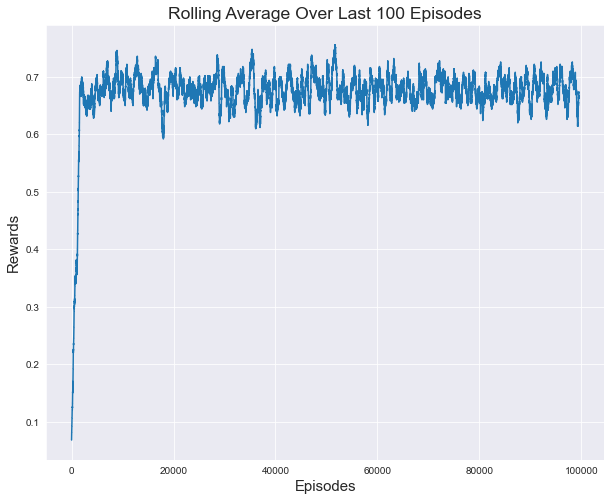

In [145]:
qlearn.plot_rewards_per_episode()

In [128]:
class DoubleQLearningAgent():
    
    def __init__(self, env, state_space, lr, min_epsilon, gamma):
        
        self.env = env
        self.state_space = state_space
        self.Q_table_1 = np.zeros((self.state_space,) + (self.env.action_space.n,))
        self.Q_table_2 = np.zeros((self.state_space,) + (self.env.action_space.n,))
        self.lr = lr
        self.min_epsilon = min_epsilon
        self.gamma = gamma
    
    def update_epsilon_greedy(self, episode):
        self.epsilon =  max(self.min_epsilon, min(1, 1.0 - math.log10((episode  + 1) / 25)))
    
    def get_action(self, state):
        if np.random.random() < self.epsilon:
            action = self.env.action_space.sample()
        else:
            action = np.argmax(self.Q_table[state])
        return action
    
    def train_Q(self, episodes):
        tic = time.time()
        self.reward_list = []  
        self.plot_rewards = []
        episode_reward = 0
        success = False
        for i in range(1, episodes+1):
            self.update_epsilon_greedy(i)

            current = self.env.reset()
            done = False
            while not done:

                if np.random.random() < self.epsilon:
                    action = env.action_space.sample()
                else:
                    action = np.argmax(self.Q_table_1[current] + self.Q_table_2[current])

                observation, reward, done, info = self.env.step(action) 
                next_state = observation
                
                if np.random.random() < 0.5:
                    self.Q_table_1[current][action] += self.lr*(reward + (self.gamma*self.Q_table_2[next_state][np.argmax(self.Q_table_1[next_state])]) - self.Q_table_1[current][action])
                else:
                    self.Q_table_2[current][action] += self.lr*(reward + (self.gamma*self.Q_table_1[next_state][np.argmax(self.Q_table_2[next_state])]) - self.Q_table_2[current][action])
                current = next_state

                episode_reward += reward
            
            self.reward_list.append(episode_reward)
            if i >= 500:
                self.plot_rewards.append(np.mean(self.reward_list[-500:]))
            episode_reward = 0
            
        toc = time.time()
        print(f'Finished training state-action function in {toc-tic:.2f} seconds')
        print('=================================================================')
        print(self.Q_table_1)
        print('-----------------------------------------------------------------')
        print(self.Q_table_2)
        return f'Total rewards over {episodes} episodes: {np.sum(self.reward_list)} and {np.mean(self.reward_list):.2f} average rewards'
    
    def test_Q(self, episodes):
        rewards = []
        episode_reward = 0
        for i in range(1, episodes+1):
            current = env.reset()
            done = False
            while not done:
                action = np.argmax(self.Q_table_1[current] + self.Q_table_2[current])
                observation, reward, done, info = env.step(action)
                next_state = observation
                episode_reward += reward
                current = next_state
            rewards.append(episode_reward)
            episode_reward = 0
        return f'Total rewards over {episodes} episodes: {np.sum(rewards)} and reached the goal {np.sum(rewards)/episodes}% of the time'
    
    def plot_rewards_per_episode(self):
        f, ax = plt.subplots(figsize=(10,8))
        sns.lineplot(x=range(len(self.plot_rewards)), y=self.plot_rewards, ax=ax, color='r')
        ax.set_title('Rolling Average Over Last 100 Episodes', size=17.5)
        ax.set_ylabel('Rewards', size=15)
        ax.set_xlabel('Episodes', size=15)

In [129]:
double_qlearn = DoubleQLearningAgent(env=gym.make('FrozenLake-v0'), state_space=16, lr=0.1, min_epsilon=0.05, gamma=0.99)

In [130]:
double_qlearn.train_Q(200000)

Finished training state-action function in 152.89 seconds
[[0.47257801 0.3659709  0.39749633 0.40148364]
 [0.14726792 0.10938227 0.07698056 0.32127517]
 [0.11579561 0.10756128 0.11794686 0.23543835]
 [0.06494453 0.09225139 0.06991112 0.163578  ]
 [0.49500778 0.34071349 0.2598723  0.2699741 ]
 [0.         0.         0.         0.        ]
 [0.14612283 0.1058283  0.33769302 0.10266699]
 [0.         0.         0.         0.        ]
 [0.29450931 0.32427451 0.3584901  0.52582036]
 [0.18001031 0.63442709 0.42380293 0.33966758]
 [0.5060749  0.30552221 0.23052228 0.2085997 ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.37985628 0.39843947 0.74176951 0.42952933]
 [0.58180669 0.82577555 0.66783258 0.6312187 ]
 [0.         0.         0.         0.        ]]
-----------------------------------------------------------------
[[0.47015076 0.38336973 0.42837193 0.37923392]
 [0.12316815 0.12198945 0.11024488 0.31547278]
 [0.13106158 0.13284773 0.102

'Total rewards over 200000 episodes: 81106.0 and 0.41 average rewards'

In [131]:
double_qlearn.test_Q(10000)

'Total rewards over 10000 episodes: 7423.0 and reached the goal 0.7423% of the time'

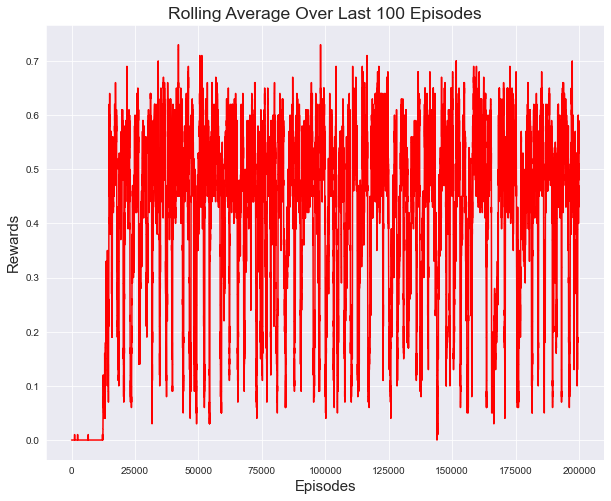

In [132]:
double_qlearn.plot_rewards_per_episode()

In [149]:
np.argmax(double_qlearn.Q_table_1[0] + double_qlearn.Q_table_2[0])

0